<a href="https://colab.research.google.com/github/bartoszkozakiewicz/DeepLearning/blob/main/MASK_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ENV PREPARATION

In [25]:
import os
os.chdir("/content/drive/MyDrive/MaskNew_RCNN/x/")

# Root directory of the project
ROOT_DIR = "/content/drive/MyDrive/MaskNew_RCNN/x"

# Tworzymy pełną ścieżkę do pliku requirements.txt
requirements_path = os.path.join(ROOT_DIR, 'requirements.txt')
# Tworzymy pełną ścieżkę do pliku setup.py
setup_path = os.path.join(ROOT_DIR, 'setup.py')

In [26]:
# Instalujemy pakiety z pliku requirements.txt
!pip install -r {requirements_path}

# !python3 setup.py install

#TRAINING

In [27]:
import sys
import random
import math
import json
import skimage
import imgaug
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils


In [28]:
class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"


    # NUMBER OF GPUs to use. When using only a CPU, this needs to be set to 1.
    GPU_COUNT = 1

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 4

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + Hard_hat, Safety_vest

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 5

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

    LEARNING_RATE = 0.001

In [19]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Dog-Cat dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.

        # Add classes. We have only one class to add.
        self.add_class("object", 1, "paragon")



        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, f"{subset}.json")))
        print("1 etap: ",annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys
        print("2 etap: ",len(annotations),"\n")

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]
        print("3 etap: ",len(annotations),"\n")

        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            polygons = [r['shape_attributes'] for r in a['regions']]
            objects = [s['region_attributes']['names'] for s in a['regions']]
            # print("4 etap objects:",objects , "\n", "polygons: ",polygons)
            name_dict = {"paragon": 1}

            # key = tuple(name_dict)
            num_ids = [name_dict[a] for a in objects]
            # print("5 etap: ",num_ids,"\n")

            # num_ids = [int(n['Event']) for n in objects]
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [20]:
def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom("/content/drive/MyDrive/MaskNew_RCNN/x/dataset", "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom("/content/drive/MyDrive/MaskNew_RCNN/x/dataset", "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.

    # print("Training network heads")
    # model.train(dataset_train, dataset_val,
                # learning_rate=config.LEARNING_RATE,
                # epochs=250,
                # layers='heads')

    # print(dataset_val.class_names)
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=300,
                layers='heads', #layers='all',
                augmentation = imgaug.augmenters.Sequential([
                imgaug.augmenters.Fliplr(1),
                imgaug.augmenters.Flipud(1),
                imgaug.augmenters.Affine(rotate=(-45, 45)),
                imgaug.augmenters.Affine(rotate=(-90, 90)),
                imgaug.augmenters.Affine(scale=(0.5, 1.5)),
                imgaug.augmenters.Crop(px=(0, 10)),
                imgaug.augmenters.Grayscale(alpha=(0.0, 1.0)),
                imgaug.augmenters.AddToHueAndSaturation((-20, 20)), # change hue and saturation
                imgaug.augmenters.Add((-10, 10), per_channel=0.5), # change brightness of images (by -10 to 10 of original value)
                imgaug.augmenters.Invert(0.05, per_channel=True), # invert color channels
                imgaug.augmenters.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)), # sharpen images

                ]

                ))

In [21]:
# Directory to save logs and trained model
MODEL_LOGS_WEIGHTS_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")


config = CustomConfig()
model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=MODEL_LOGS_WEIGHTS_DIR)

weights_path = COCO_MODEL_PATH
        # Download weights file
if not os.path.exists(weights_path):
  utils.download_trained_weights(weights_path)

model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])

train(model)

1 etap:  {'000007_jpg.rf.51fe3dce4785ad15625ab6b474b78d80.jpg306666': {'filename': '000007_jpg.rf.51fe3dce4785ad15625ab6b474b78d80.jpg', 'size': 306666, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [208, 204, 1369, 1403], 'all_points_y': [98, 1966, 1992, 71]}, 'region_attributes': {'names': 'paragon'}}], 'file_attributes': {}}, '000008_jpg.rf.32a579f3844405812cb6d6f5b7655b95.jpg168255': {'filename': '000008_jpg.rf.32a579f3844405812cb6d6f5b7655b95.jpg', 'size': 168255, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [1, 1274, 1275, 3], 'all_points_y': [120, 84, 814, 820]}, 'region_attributes': {'names': 'paragon'}}], 'file_attributes': {}}, '000009_jpg.rf.797cbfc035858e3cbe7c8302c842e6d1.jpg260497': {'filename': '000009_jpg.rf.797cbfc035858e3cbe7c8302c842e6d1.jpg', 'size': 260497, 'regions': [{'shape_attributes': {'name': 'polygon', 'all_points_x': [388, 760, 1076, 1408, 1607, 1840, 1772, 1490, 1227, 987, 378], 'all_points_y': [134, 98, 88, 1

#ENV PREPARATION

In [29]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils
MODEL_LOGS_WEIGHTS_DIR = os.path.join(ROOT_DIR, "logs")


#INFERENCE

In [30]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# Creates a session with device placement logs
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
print(sess)

Num GPUs Available:  0
Device mapping: no known devices.


In [33]:
class InferenceConfig(CustomConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    #Minimum probability value to accept a detected instance
    # ROIs below this threshold are skipped
    DETECTION_MIN_CONFIDENCE = 0.9

    # Non-maximum suppression threshold for detection
    DETECTION_NMS_THRESHOLD = 0.3

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir=MODEL_LOGS_WEIGHTS_DIR)

#model_path = model.find_last()
model_path = os.path.join(ROOT_DIR,'mask_rcnn_my.h5')


# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/MyDrive/MaskNew_RCNN/x/mask_rcnn_my.h5


Processing 1 images
image                    shape: (1280, 960, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


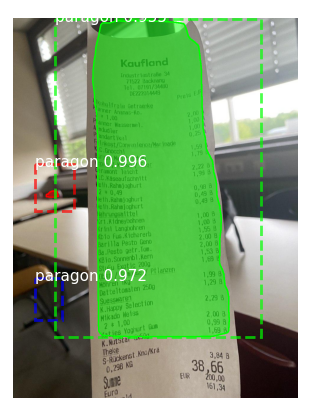

Processing 1 images
image                    shape: (1280, 960, 3)        min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


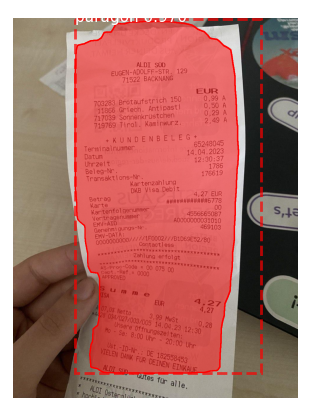

In [34]:
real_test_dir = ROOT_DIR
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))
# print(image_paths)
for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'],
                                ['BG', 'paragon'], r['scores'], figsize=(5,5)) # uniwersalne branie klas:dataset_val.class_names

First tests are corrent, next huge dataset and long training...